<div style="text-align:center; font-family: 'Arial', sans-serif; margin-top: 30px; background-color:#f5f7fa; padding:20px; border-radius:15px; box-shadow: 0 4px 10px rgba(0,0,0,0.1);">
    <h1 style="color:#1E90FF; font-size: 50px; margin-bottom: 10px;">Intel Scene Classifier</h1>
    <p style="color:#555; font-size: 20px; margin-bottom:5px;">by <strong>Seif Eldeen</strong></p>
    <p style="color:#333; font-size: 18px; max-width: 800px; margin:auto; line-height:1.5;">
        This project demonstrates a Convolutional Neural Network (CNN) trained to classify images into six categories: <strong>Mountain, Sea, Street, Glacier, Forest, and Building</strong>.
        It includes data visualization, model training with early stopping, and prediction on both test and new images. The network architecture combines multiple convolutional layers with dense layers and dropout for regularization.
    </p>
    <hr style="width:50%; margin:auto; border:2px solid #1E90FF; margin-top:20px;">
</div>


<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">1) Importing Libraries</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this section, we import all the necessary Python libraries required for data processing, visualization, and building our Convolutional Neural Network (CNN) model.
    </p>
</div>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-14 21:28:31.688435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760477311.974651      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760477312.056132      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">2) Data Visualization</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        Here we explore the dataset by visualizing sample images from each class to understand the variety and structure of the data.
    </p>
</div>

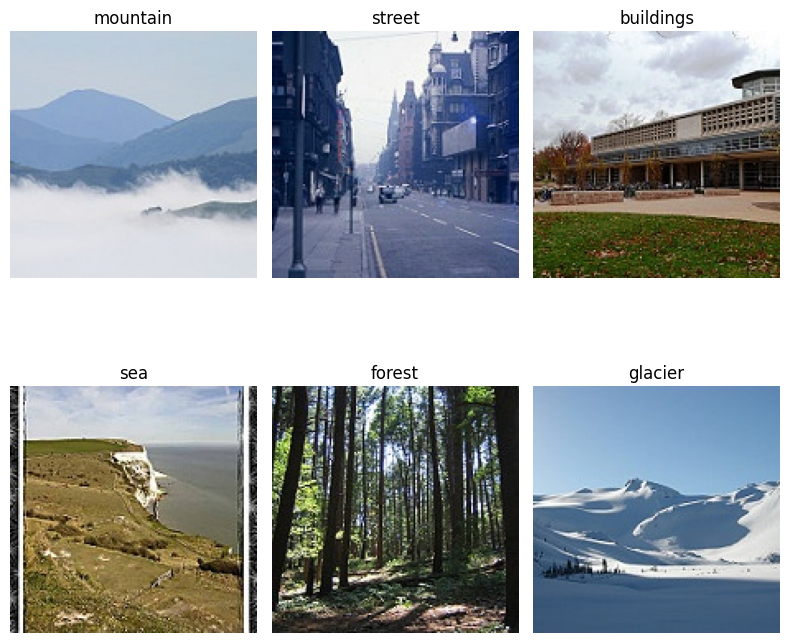

In [2]:
# Paths to train, test, and prediction folders

train_folder_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_folder_path ='/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_folder_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

plt.figure(figsize=(8, 8))

# Function to visualize one sample image from each class
def VisualAllClasses(folder_path):
    classes_folder = os.listdir(folder_path) # list all classes
    for i,cat in enumerate(classes_folder):
        images_folder_path = os.path.join(folder_path,cat)
        images_names = os.listdir(images_folder_path)
        first_image_name = images_names[0]
        first_image_path = os.path.join(images_folder_path,first_image_name)
        img = load_img(first_image_path)  # load image
        image_arr = img_to_array(img)/255 # normalize

        plt.subplot(2,3,i+1)
        plt.imshow(image_arr)
        plt.title(cat)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display sample images from all classes
VisualAllClasses(train_folder_path)     

<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">3) Data Preprocessing</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this step, we normalize the images, resize them to a consistent shape, and prepare train and test generators for feeding into the CNN model.
    </p>
</div>

In [3]:
# Create ImageDataGenerator for training (normalizes images)
train_generator = ImageDataGenerator(rescale = 1/255)
train_image_generator = train_generator.flow_from_directory(
                                            train_folder_path,
                                            target_size=(150, 150), # Resize all images to 150x150
                                            batch_size=32, # Number of images per batch
                                            class_mode='categorical') # Multi-class classification

# Create ImageDataGenerator for testing (normalizes images)
test_generator = ImageDataGenerator(rescale = 1/255)
test_image_generator = test_generator.flow_from_directory(
                                            test_folder_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
# Get the class names from the training generator
class_names = list(train_image_generator.class_indices.keys())

<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">4) Model Architecture</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        This section defines the Convolutional Neural Network structure, including convolutional layers, max-pooling layers, dense layers, and dropout layers for regularization.
    </p>
</div>

In [5]:
# Initialize the Sequential model
model = Sequential()

# Convolutional layers with increasing filters and max pooling
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding="same",activation='relu',input_shape=[150,150,3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation='relu',input_shape=[150,150,3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding="same",activation='relu',input_shape=[150,150,3]))
model.add(MaxPooling2D(2))

# Flatten the 3D feature maps to 1D
model.add(Flatten())

# Fully connected layers with dropout for regularization
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.35))

# Output layer for 6 classes with softmax activation
model.add(Dense(6,activation='softmax'))

# Display model architecture
model.summary()


2025-10-14 21:29:04.367850: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,486 (10.55 MB)

 Trainable params: 2,764,486 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">5) Model Training</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        The model is compiled and trained on the training dataset with early stopping to prevent overfitting. Training and validation accuracy and loss are monitored across epochs.
    </p>
</div>

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,              # Stop if no improvement for 5 epochs
    restore_best_weights=True # Restore the model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(
    train_image_generator,
    epochs = 100,
    verbose = 1,
    callbacks = early_stopping,
    validation_data = test_image_generator
)

Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 363s 816ms/step - accuracy: 0.3535 - loss: 1.5230 - val_accuracy: 0.6193 - val_loss: 0.9882
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 346s 787ms/step - accuracy: 0.5790 - loss: 1.0384 - val_accuracy: 0.6847 - val_loss: 0.8268
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 360s 820ms/step - accuracy: 0.6341 - loss: 0.9131 - val_accuracy: 0.7183 - val_loss: 0.7314
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 344s 784ms/step - accuracy: 0.7056 - loss: 0.7756 - val_accuracy: 0.7773 - val_loss: 0.6461
Epoch 5/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 382s 784ms/step - accuracy: 0.7489 - loss: 0.6844 - val_accuracy: 0.8150 - val_loss: 0.5484
Epoch 6/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 403s 832ms/step - accuracy: 0.7853 - loss: 0.5956 - val_accuracy: 0.8020 - val_loss: 0.5657
Epoch 7/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 342s 779ms/step - accuracy: 0.8136 - loss: 0.5282 - val_accuracy: 0.8027 - val_loss: 0.5721
Epoch 8/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 345s 785ms/step - accuracy: 

<div style="background-color:#f0f0f0; color:#333; padding:10px 20px; border-radius:8px; font-family:'Arial', sans-serif; margin-top:10px; margin-bottom:10px; border-left:5px solid #32CD32;">
    <p style="font-size:16px; line-height:1.5; font-style:italic;">
        <strong>Observation:</strong> During training, I closely monitored the model’s performance to prevent <strong>overfitting</strong>. 
        I experimented with different <strong>Dropout</strong> values and adjusted the number of <strong>neurons</strong> in each dense layer until I achieved a balanced model with stable validation accuracy and minimal loss fluctuation.
    </p>
</div>


<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">6) Training Visualization</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        We plot the training and validation loss and accuracy curves to observe the model's performance and check for overfitting or underfitting.
    </p>
</div>

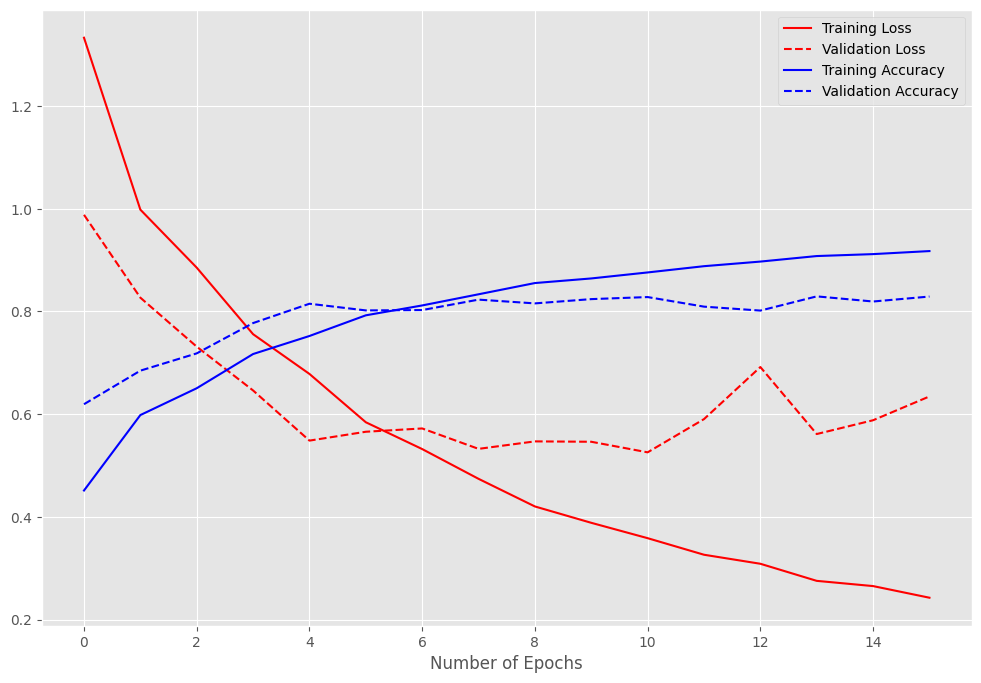

In [7]:
# Get the training history
h = hist.history

# Set plotting style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')

# Plot training and validation accuracy
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">7a) Predictions on Test Dataset Images</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this section, we use the trained model to predict classes for images from the test dataset. This helps us evaluate how well the model generalizes to unseen data from the same source.
    </p>
</div>

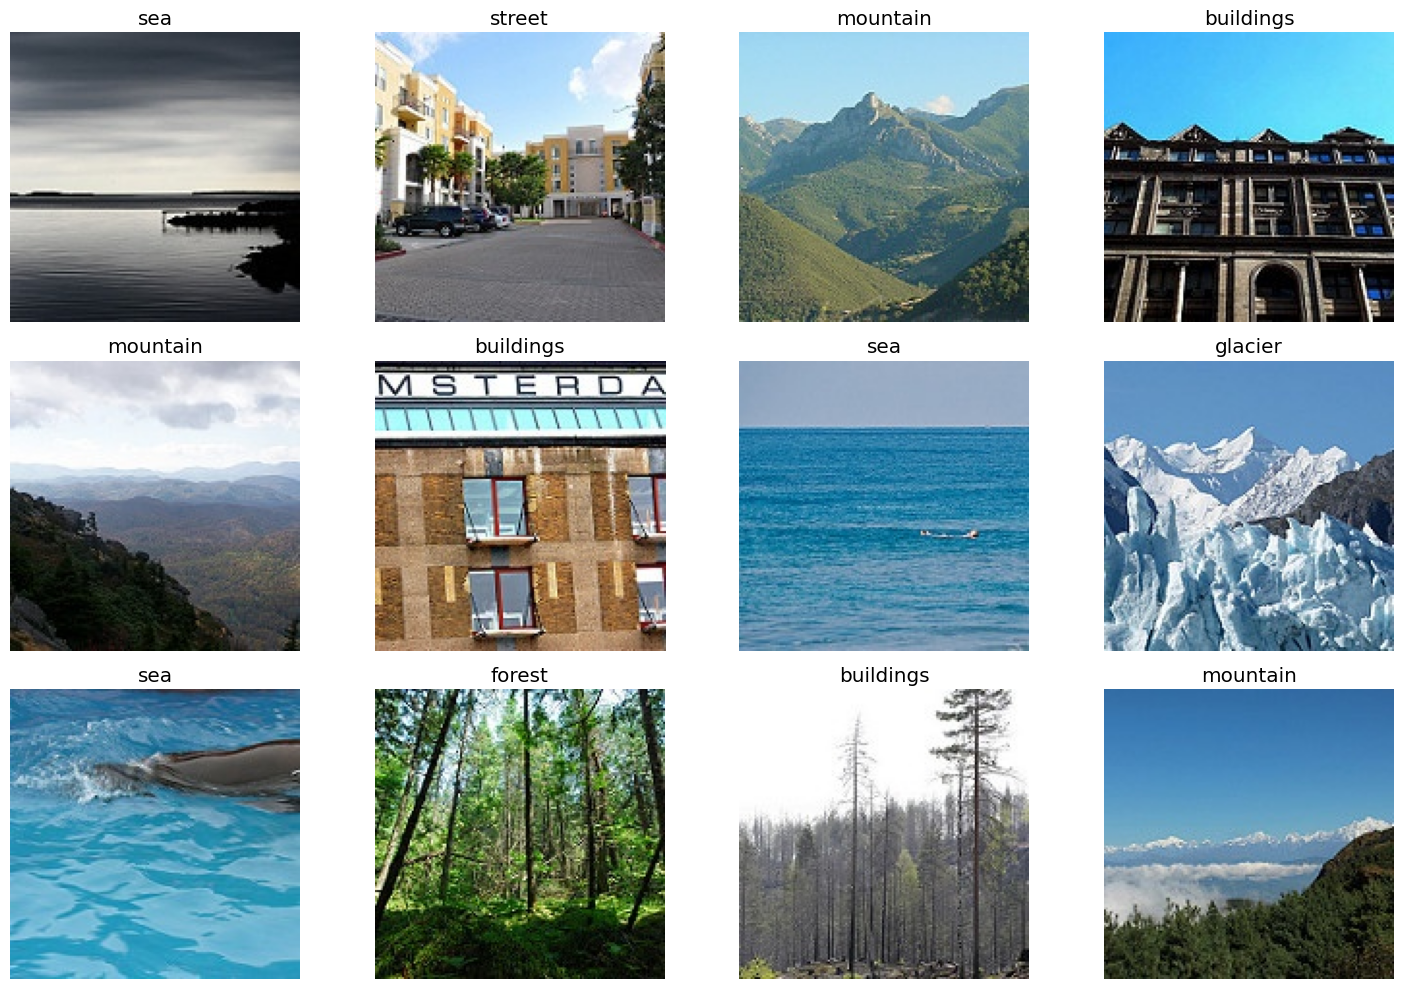

In [8]:
plt.figure(figsize=(15, 10))

# Loop over first 12 images in the prediction folder
for i in range(12):
    fname = os.listdir(pred_folder_path)[i]
    path = os.path.join(pred_folder_path, fname)
    
    # Load and preprocess the image
    img = load_img(path, target_size=(150,150))
    img_array = img_to_array(img)/255.0
    img_array_exp = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    pred = model.predict(img_array_exp, verbose=0)
    class_index = np.argmax(pred, axis=1)[0]
    label = class_names[class_index]    

    # Display image with predicted label
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

<div style="background-color:#f0f0f0; color:#333; padding:10px 20px; border-radius:8px; font-family:'Arial', sans-serif; margin-top:10px; margin-bottom:10px; border-left:5px solid #1E90FF;">
    <p style="font-size:16px; line-height:1.6; font-style:italic;">
        <strong>Observation:</strong> Out of 12 test images, 10 were correctly classified (<strong>Accuracy: 83.33%</strong>). 
        Two images were misclassified:
        <br>• <strong>Image 11:</strong> Forest → classified as Building
        <br>• <strong>Image 5:</strong> Building → classified as Street
    </p>
</div>


<div style="background-color:#1E90FF; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">7b) Predictions on External Images</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        Here, we predict classes for images collected from external sources, such as Google or personal photos. This allows us to test the model on completely new images and check its real-world performance.
    </p>
</div>

In [9]:
def PredictImageFromPath(image_path):

     # Load and preprocess the image
    img = load_img(image_path, target_size=(150,150))
    img_array = img_to_array(img)/255.0
    img_array_exp = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Make prediction
    pred = model.predict(img_array_exp, verbose=0)
    class_index = np.argmax(pred, axis=1)[0]
    label = class_names[class_index]    

    # Display the image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()
    

    

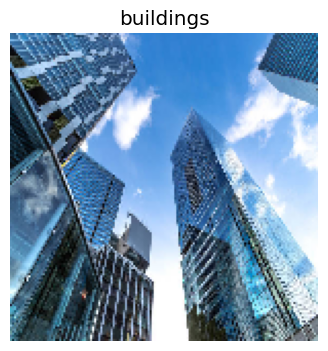

In [10]:
PredictImageFromPath('/kaggle/input/building/istockphoto-1696781145-612x612.jpg')

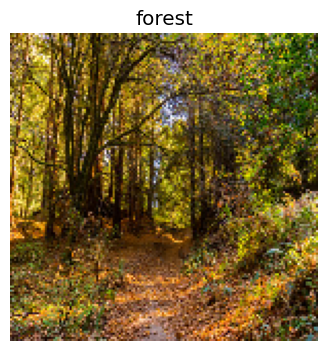

In [11]:
PredictImageFromPath('/kaggle/input/forest/360_F_186176639_tB8an8LO0YrYluMmBAWWhK1gsV7r264m.jpg')

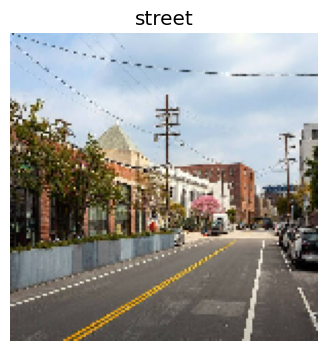

In [12]:
PredictImageFromPath('/kaggle/input/street/image.jpg')